### Correlating Objective Loss Values and Metrics


In [18]:
file_name = "HPT_Nov_09_Evaluated"
folder_name = "z_results"
columns_to_correlate = [
    # "after_train_eval_obj", # The collumn to correlate with alternatively with val_obj
    "val_obj",
    "eval_Txt2Audio_mAP",
    "eval_Txt2Audio_R10",
    "eval_Txt2Audio_R5",
    # "eval_Txt2Audio_R1",
    "eval_Audio2Txt_mAP",
    "eval_Audio2Txt_R10",
    "eval_Audio2Txt_R5",
    # "eval_Audio2Txt_R1",
    "val_Txt2Audio_mAP",
    "val_Txt2Audio_R10",
    "val_Txt2Audio_R5",
    # "val_Txt2Audio_R1",
    "val_Audio2Txt_mAP",
    "val_Audio2Txt_R10",
    "val_Audio2Txt_R5",
    # "val_Audio2Txt_R1",
]
to_correlate_with = "after_train_eval_obj"

/tmp/ipykernel_3285535/290927867.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_3285535/290927867.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_3285535/290927867.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_3285535/290927867.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


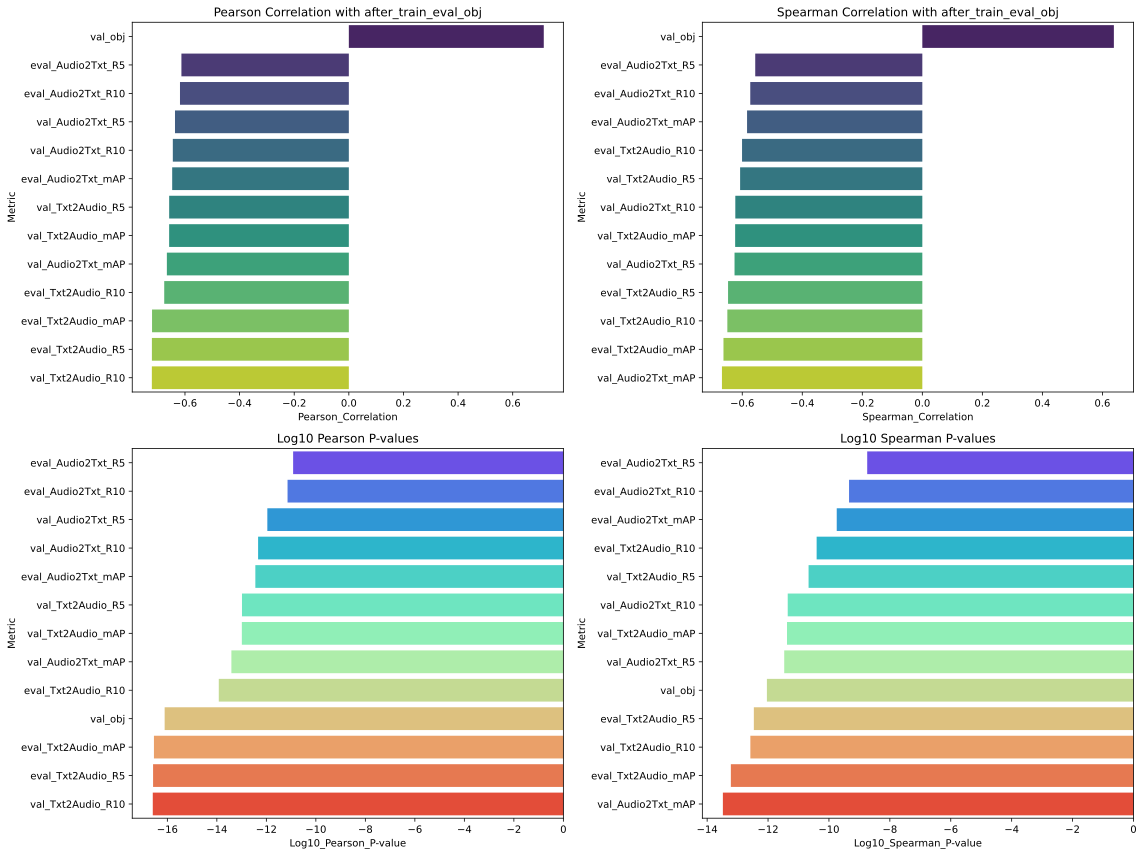

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import os
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")
# Load CSV data

csv_path = f"../{folder_name}/{file_name}.csv"  # adjust path if needed
df = pd.read_csv(csv_path)

# Columns to correlate with "val_obj"


# Calculate Pearson and Spearman correlations with "val_obj" and their p-values
pearson_corrs = {}
spearman_corrs = {}

for col in columns_to_correlate:
    pearson_corr, pearson_pval = stats.pearsonr(
        df[f"{to_correlate_with}"], df[col]
    )
    spearman_corr, spearman_pval = stats.spearmanr(
        df[f"{to_correlate_with}"], df[col]
    )

    pearson_corrs[col] = (pearson_corr, pearson_pval)
    spearman_corrs[col] = (spearman_corr, spearman_pval)

# Create dataframes for correlations and p-values (log transformed)
pearson_df = pd.DataFrame(
    [
        (
            col,
            pearson_corrs[col][0],
            (
                np.log10(pearson_corrs[col][1])
                if pearson_corrs[col][1] > 0
                else 0
            ),
        )
        for col in columns_to_correlate
    ],
    columns=["Metric", "Pearson_Correlation", "Log10_Pearson_P-value"],
)

spearman_df = pd.DataFrame(
    [
        (
            col,
            spearman_corrs[col][0],
            (
                np.log10(spearman_corrs[col][1])
                if spearman_corrs[col][1] > 0
                else 0
            ),
        )
        for col in columns_to_correlate
    ],
    columns=["Metric", "Spearman_Correlation", "Log10_Spearman_P-value"],
)

# Log the Pearson and Spearman p-values after transformation
# print("Logged Pearson and Spearman Correlations and Log10 P-values:\n")
# print("Pearson Correlations and Log10 P-values:")
# print(pearson_df)
# print("\nSpearman Correlations and Log10 P-values:")
# print(spearman_df)

# Plot correlations and log-transformed p-values with 'lava' colormap
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=150)

# Pearson Correlation Plot with lava colormap
sns.barplot(
    data=pearson_df.sort_values(by="Pearson_Correlation", ascending=False),
    x="Pearson_Correlation",
    y="Metric",
    ax=axes[0, 0],
    palette="viridis",  # 'viridis' is similar to 'lava' and provides a vibrant color scale
)
axes[0, 0].set_title(f"Pearson Correlation with {to_correlate_with}")


# Spearman Correlation Plot with lava colormap
sns.barplot(
    data=spearman_df.sort_values(by="Spearman_Correlation", ascending=False),
    x="Spearman_Correlation",
    y="Metric",
    ax=axes[0, 1],
    palette="viridis",
    legend=True,
)
axes[0, 1].set_title(f"Spearman Correlation with {to_correlate_with}")

# Log10 Pearson P-value Plot with lava colormap
sns.barplot(
    data=pearson_df.sort_values(by="Log10_Pearson_P-value", ascending=False),
    x="Log10_Pearson_P-value",
    y="Metric",
    ax=axes[1, 0],
    palette="rainbow",
    legend=True,
)
axes[1, 0].set_title("Log10 Pearson P-values")

# Log10 Spearman P-value Plot with lava colormap
sns.barplot(
    data=spearman_df.sort_values(by="Log10_Spearman_P-value", ascending=False),
    x="Log10_Spearman_P-value",
    y="Metric",
    ax=axes[1, 1],
    palette="rainbow",
    legend=True,
)
axes[1, 1].set_title("Log10 Spearman P-values")

output_path = f"../{folder_name}/{to_correlate_with}_{file_name}.svg"
# Adjust layout for better presentation
plt.tight_layout()
plt.savefig(output_path, bbox_inches="tight", format="svg")
plt.show()

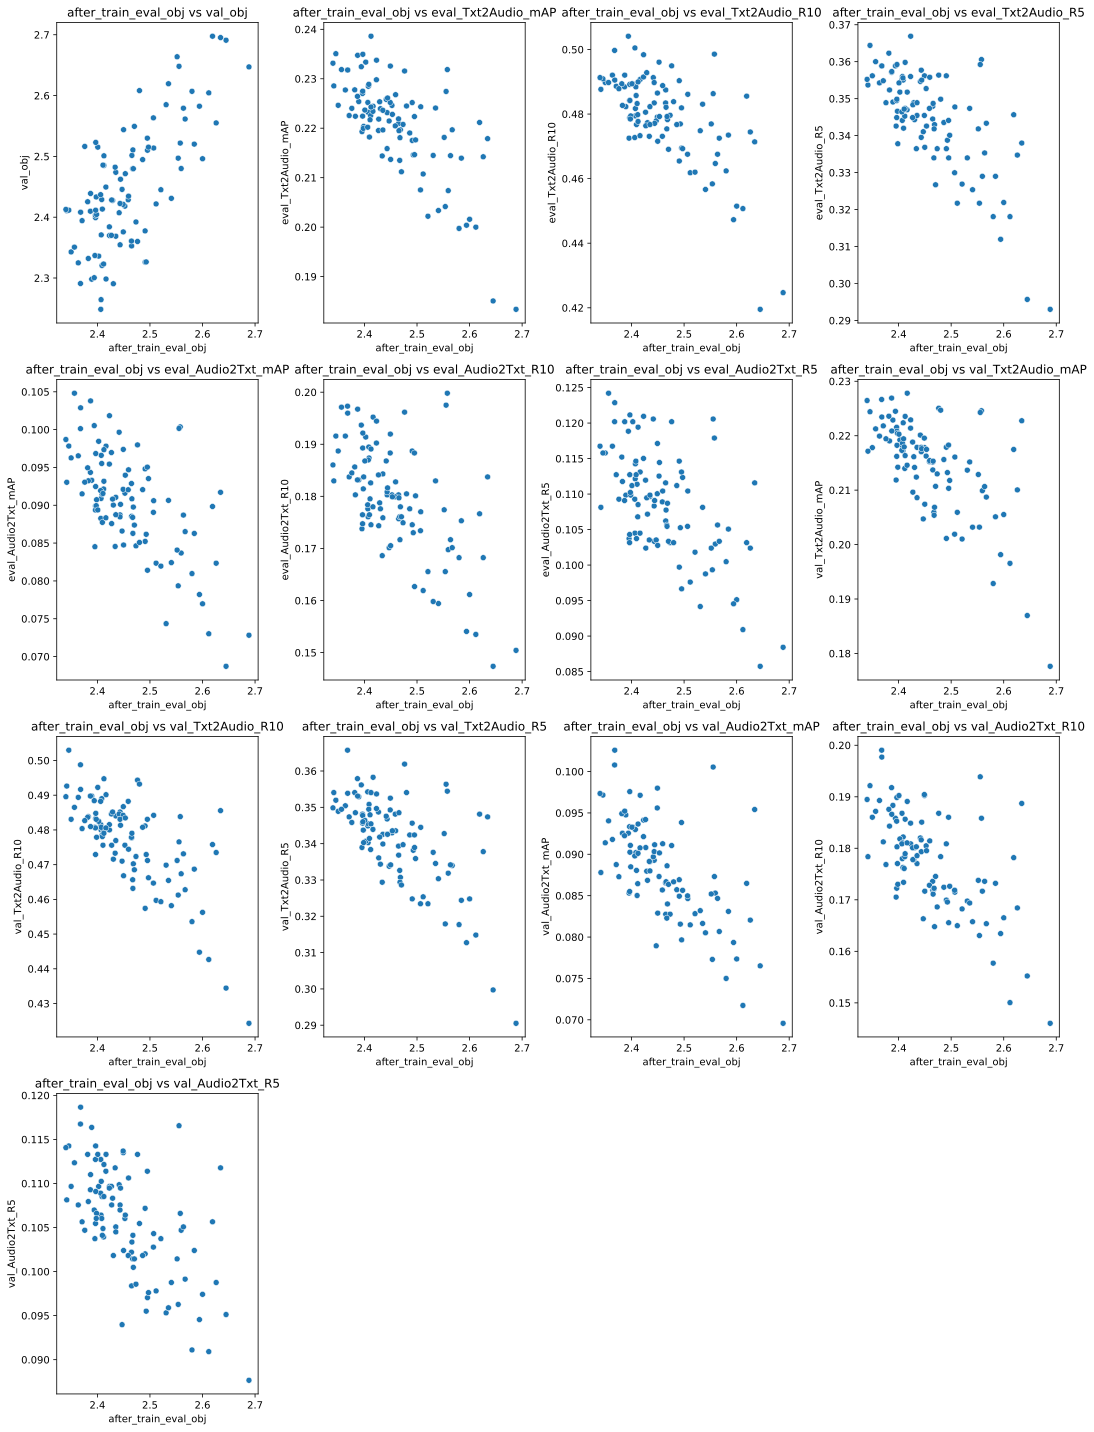

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(15, 20), dpi=150)

# Iterate over each column and create a scatter plot or other plot
for i, col in enumerate(columns_to_correlate, 1):
    plt.subplot(4, 4, i)  # Create a grid of subplots (5 rows, 3 columns)

    # Plot scatter plot
    sns.scatterplot(x=df[f"{to_correlate_with}"], y=df[col])

    # Set the title and labels
    plt.title(f"{to_correlate_with} vs {col}")
    plt.xlabel(f"{to_correlate_with}")
    plt.ylabel(col)

output_path = f"../{folder_name}/{to_correlate_with}_{file_name}_scatter.svg"
plt.tight_layout()
plt.savefig(output_path, bbox_inches="tight", format="svg")
plt.show()